In [1]:
import setup
from imports import *
from buffer import Transition, MemoryRing
from plotting import *
from make_movie import make_movie
from sys import maxsize

In [2]:
setup.check_my_system()

You have a CUDA capable machine
Available GPU(s):
	cuda:0 TITAN V (CUDA version 7.0)
	cuda:1 GeForce GTX 1050 Ti (CUDA version 6.1)

Your AI Gym enviornment is correctly set up.


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import call_center_sim

In [5]:
env_name = 'call-center-sim-v1'
env = gym.make(env_name).unwrapped

# You can generally find this in the Gym docs or get a decent guess by looking at the code.
target_avg_reward = 20000
over_n_episodes = 100

# The maximum number of iterations to go before giving up if we haven't achieved our targets
# If the previous values are good, this means we're likely stuck in a local minima
max_training_iterations = 10000

# For episodes that don't end on their own, setting a max loss is helpful
max_loss = -20

In [6]:
obs, reward, done, debug = env.step(1)

In [7]:
# Calculate dynamic settings based on selected environment

env.reset()
next_state, _, _, _ = env.step(env.action_space.sample())
input_tensor_size = len(next_state)
output_tensor_size = env.action_space.n

In [8]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.inputLayer = nn.Linear(input_tensor_size, 128)
        self.drop1 = nn.Dropout(0.2)
        self.hiddenLayer1 = nn.Linear(128, 64)
        self.outputLayer = nn.Linear(64, output_tensor_size)
        
    def forward(self, state):
        x = F.relu(self.inputLayer(state))
        x = self.drop1(x)
        x = F.relu(self.hiddenLayer1(x))
        x = F.relu(self.outputLayer(x))
        return x

In [9]:
class Agent(object):
    def __init__(self, lr, action_space_size, eps_max = 0.9, eps_min = 0.05, eps_decay = 0.998):
        self.learning_rate = lr
        self.epsilon_max = eps_max
        self.epsilon_min = eps_min
        self.epsilon_current = eps_max
        self.epsilon_decay = eps_decay
        self.action_space_size = action_space_size
        
        self.memory = MemoryRing(2**16)
        self.decay_timer = 0
        self.gamma = 0.999
        self.batch_size = 32
        self.step = 0
        
        self.policy_net = DQN().to(device)
        self.target_net = DQN().to(device)
        
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.target_net_update = 50
        
        self.loss = torch.nn.MSELoss()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        
    def learn_from_past_experiences(self):
        if not self.memory.can_sample(self.batch_size):
            return
        self.decay_timer += 1
        if self.decay_timer % 2 == 0:
            self.epsilon_current = max(self.epsilon_current * self.epsilon_decay, self.epsilon_min)
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        non_termimal_entries = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.uint8)
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        next_state_values = torch.zeros(self.batch_size, device=device)
        next_state_values[non_termimal_entries] = self.target_net(non_terminal_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma) + reward_batch
        
        loss = self.loss(state_action_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.policy_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
    def remember_experience(self, state, action, reward, next_state):
        self.memory.push(state, action, reward, next_state)
        
    def choose_next_action(self, state, explore = True):
        be_greedy = random.random()
        current_eps = self.epsilon_current
        self.step += 1
        if ((be_greedy > current_eps) or not explore):
            with torch.no_grad():
                return self.policy_net(state).max(1)[1].view(1,1)
        else:
            return torch.tensor([[random.randrange(self.action_space_size)]], device=device, dtype=torch.long)
    
    def end_round_of_experiences(self, episode_number):
        if episode_number % self.target_net_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
            self.target_net.eval()
    
    def load_brain(self, prefix):
        self.policy_net.load_state_dict(torch.load(f"{prefix}_policy_q_net.pytorch"))
        self.policy_net.eval()
        self.target_net.load_state_dict(torch.load(f"{prefix}_target_q_net.pytorch"))
        self.target_net.eval()
        
    def save_brain(self, prefix):
        torch.save(self.policy_net.state_dict(), f"{prefix}_policy_q_net.pytorch")
        torch.save(self.target_net.state_dict(), f"{prefix}_target_q_net.pytorch")
    

In [13]:
import matplotlib.pyplot as plt
def run_training_loop(agent, live_pod_utilization = False, end_pod_utilization = False):
    tracker = RewardTracker()
    
    rolling_total_reward = [-maxsize-1 for i in range(over_n_episodes)];
    
    for episode in range(max_training_iterations):
        state = env.reset()
        done= False
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)
        episode_total_reward = 0
        steps_survived = 0
        while not done and episode_total_reward > max_loss:
            steps_survived += 1
            action = agent.choose_next_action(state)
            next_state, reward, done, dbg = env.step(action.item())
            episode_total_reward += reward
            reward = torch.tensor([reward], dtype=torch.float).to(device)
            if done:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0).to(device)
            
            agent.remember_experience(state, action, reward, next_state)
            state = next_state
            if live_pod_utilization:
                queues = dbg['current_state'][:-1]
                y_pos = np.arange(len(queues))
                plt.close()
                plt.bar(y_pos, queues)
                plt.xticks(y_pos, [x+1 for x in range(len(queues))])
                clear_output(wait=True)
                display(plt.gcf())
                
            agent.learn_from_past_experiences()
            if done or (episode_total_reward <= max_loss):
                tracker.push(episode_total_reward)
                rolling_total_reward[episode % over_n_episodes] = episode_total_reward
                if not live_pod_utilization and not end_pod_utilization:
                    clear_output(wait=True)
                    tracker.plot()
                    print(f"Steps survived: {steps_survived} Reward: {episode_total_reward}")
                
                if end_pod_utilization:
                    queues = dbg['current_state'][:-1]
                    y_pos = np.arange(len(queues))
                    plt.bar(y_pos, queues)
                    plt.xticks(y_pos, [x+1 for x in range(len(queues))])
                    clear_output(wait=True)
                    display(plt.gcf())
                    plt.close()
                
                if np.mean(rolling_total_reward) >= target_avg_reward:
                    agent.end_round_of_experiences(episode)
                    agent.save_brain(f"{env_name.lower()}_{episode}_ep")
                    print(f'Target achieved in {episode} episodes')
                    return
            
        agent.end_round_of_experiences(episode)
    agent.save_brain(f"{env_name.lower()}_{over_n_episodes}_ep")
    print('Episode limit expired')

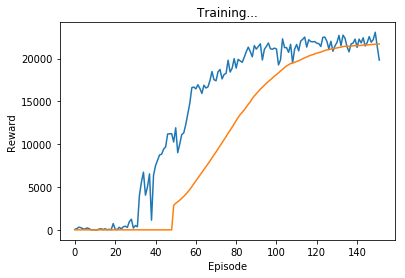

Steps survived: 2000 Reward: 19816.275383230804
Target achieved in 151 episodes


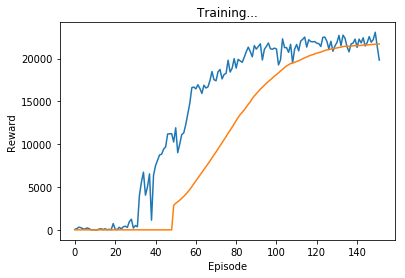

In [14]:
agent = Agent(0.0001, env.action_space.n)
# if you'd reather start with a pretrained network, remove the comment from the one below
# agent.load_brain("call-center-sim-v1_151_ep")

# Use the following call to see live pod utilization during training
# run_training_loop(agent, live_pod_utilization=True)

# Use the following call to see pod utilization at the end of each run
# run_training_loop(agent, end_pod_utilization=True)

# Use the following call to train the agent with the normal progress graph
run_training_loop(agent)

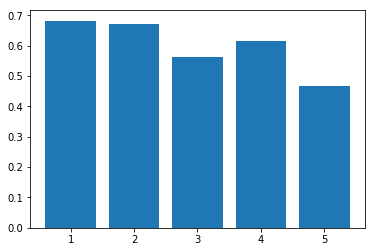

Total reward: 21117.653972188145


In [17]:
def use_agent(agent):
    done = False
    episode_total_reward = 0
    state = env.reset()
    state = torch.tensor(state, dtype=torch.float).unsqueeze(0).to(device)
    while not done:
        action = agent.choose_next_action(state, explore=False)
        next_state, reward, done, dbg = env.step(action.item())
        episode_total_reward += reward
        reward = torch.tensor([reward], dtype=torch.float).to(device)
        if done:
            next_state = None
        else:
            next_state = torch.tensor(next_state, dtype=torch.float).unsqueeze(0).to(device)
        state = next_state
        queues = dbg['current_state'][:-1]
        y_pos = np.arange(len(queues))
        plt.bar(y_pos, queues)
        plt.xticks(y_pos, [x+1 for x in range(len(queues))])
        clear_output(wait=True)
        display(plt.gcf())
        plt.close()
    print(f"Total reward: {episode_total_reward}")

use_agent(agent)